In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib as mlab
import matplotlib.pyplot as plt
import xarray as xr
import os as os
import matplotlib.gridspec as gridspec
import glob
import netCDF4 as ncdf

import time

from datetime import datetime

# Local import 

from spectra.py_spectra import *

# Two levels that are used to create mean analysis

analysis_levels  = [6,17,28]
analysis_levels  = [2,28]

# These are 45 vertical levels that the FV3 puts out - use them here to map ARW to that grid for comparison

plevels = np.asarray([100000.,  97500.,  95000.,  92500.,  90000.,  87500.,  85000.,  82500.,
                       80000.,  77500.,  75000.,  72500.,  70000.,  67500.,  65000.,  62500.,
                       60000.,  57500.,  55000.,  52500.,  50000.,  47500.,  45000.,  42500.,
                       40000.,  37500.,  35000.,  32500.,  30000.,  27500.,  25000.,  22500.,
                       20000.,  17500.,  15000.,  12500.,  10000.,   7000.,   5000.,   3000.,
                        2000.,   1000.,    700.,    500.,    200.])

plevels = np.asarray([75000.,  72500.,  70000.,  67500.,  65000.,
                      37500.,  35000.,  32500.,  30000.,  27500.])

zlevels = (1500., 1750., 2000., 2250., 2500., 8500., 8750., 9000., 9250., 9500.)
zlevels = 1000. + 250.*np.arange(45)

# Helper functions......

#--------------------------------------------------------------------------------------------------
# Interp from 3D pressure to 1D pressure (convert from hybrid to constant p-levels)

from numba import jit

@jit(nopython=True)
def interp3d_np(data, p3d, p1d, debug=True):
    
    dinterp = np.zeros((len(p1d),data.shape[1],data.shape[2]),dtype=np.float64)
    
    # if debug:
    #     print("Input  data at %d, Max/Min:  (%10.4g, %10.4g)" % (n,data.max(), data.min()))

    for i in np.arange(data.shape[2]):
        for j in np.arange(data.shape[1]):
            dinterp[:,j,i] = np.interp(p1d, p3d[:,j,i], data[:,j,i])
            
    # if debug:
    #     print("Output data at %d, Max/Min:  (%10.4g, %10.4g)\n" % (n,dinterp[n].max(), dinterp[n].min()))
 
    return dinterp

@jit(nopython=True)
def interp4d_np(data, p3d, p1d, debug=False):
        
    dinterp = np.zeros((data.shape[0],len(p1d),data.shape[2],data.shape[3]),dtype=np.float64)
    
    for n in np.arange(data.shape[0]):
        
        # if debug:
        #     print("Input  data at %d, Max/Min:  (%10.4g, %10.4g)" % (n,data[n].max(), data[n].min()))
        for i in np.arange(data.shape[3]):
            for j in np.arange(data.shape[2]):
                dinterp[n,:,j,i] = np.interp(p1d, p3d[n,:,j,i], data[n,:,j,i])
        # if debug:
        #     print("Output data at %d, Max/Min:  (%10.4g, %10.4g)\n" % (n,dinterp[n].max(), dinterp[n].min()))
    
    return dinterp

#--------------------------------------------------------------------------------------------------
#   
def add_fhour(ds, debug=False):
        
    DateAndTime = os.path.split(ds.encoding["source"])[1]  # this gets the filename from the directory
    
    if debug == True:
            print("Filename to be parsed: ", DateAndTime)
    
    DT_obj = datetime.strptime(DateAndTime.split("_")[0], "%Y%m%d%H%M") # this converts the leading YYYYMMDDHHMM
    
    if debug == True:
        print("Date Time Object from filename: ", DT_obj)
    
    init_obj = datetime.strptime(ds.date, "%Y%m%d%H")   # this gets the initialization date & time attribute from the file 

    if debug == True:
        print("Date Time Object from initialization: ", init_obj)

    fhour    = int((DT_obj - init_obj).seconds / 3600.0)  # this does a time delta and divides into hours
    
    if debug == True:
        print("Time in hours of forecast: ", init_obj)

    ds.coords['fhour']     = fhour              # attach this attribute to the dataset
    ds.coords['init_time'] = init_obj           # attach this attribute to the dataset
    
    return ds

#--------------------------------------------------------------------------------------------------
#   
def open_mfdataset_list(data_dir, pattern, debug=False):
    """
    Use xarray.open_mfdataset to read multiple netcdf files from a list.
    """
    filelist = sorted(glob.glob(os.path.join(data_dir,pattern)))
    
    if debug == True:
        print(filelist)
    
    return xr.open_mfdataset(filelist, preprocess=add_fhour, combine='nested', concat_dim=['fhour'],parallel=True)



In [7]:
#-----------------------------------------------------------------
def run_spectral_analysis(in_dir, out_dir, day):

    hrrr_file  = str(os.path.join(in_dir, "%s_HRRR_ECONUS.nc" % day))
    rrfs_file = str(os.path.join(in_dir, "%s_RRFS_ECONUS.nc" % day))
    
    print(hrrr_file)
    print(rrfs_file)
    
    # Open data sets

    hrrr = xr.open_dataset(hrrr_file) 
    rrfs = xr.open_dataset(rrfs_file)
    
    # Loop over the analy_klevels to create multiple plots

    for k in analysis_levels:

        # these five levels are averaged together

        klevels = [k-1, k, k+1]

        # Convert to numpy arrays, fill in zeros, compute horizontal TKE.

        hrrr_u = np.nan_to_num(hrrr.u_interp.isel(nz=klevels).values).astype('float64')
        hrrr_v = np.nan_to_num(hrrr.v_interp.isel(nz=klevels).values).astype('float64')
        hrrr_w = np.nan_to_num(hrrr.w_interp.isel(nz=klevels).values).astype('float64')

        hrrr_tke2 = 0.5*(hrrr_u**2 + hrrr_v**2)

        rrfs_u = np.nan_to_num(rrfs.u_interp.isel(nz=klevels).values).astype('float64')
        rrfs_v = np.nan_to_num(rrfs.v_interp.isel(nz=klevels).values).astype('float64')
        rrfs_w = np.nan_to_num(rrfs.w_interp.isel(nz=klevels).values).astype('float64')

        rrfs_tke2 = 0.5*(rrfs_u**2 + rrfs_v**2)

        # Compute spectra...

        fig = plt.figure(constrained_layout=True,figsize=(20,10))

        ylim    = [0.001,1.0e3]
        axis    = 0
        func    = get_spectra2D_POWSPEC
        func    = get_spectra2D_AVG
        PSonly  = True

        gs = gridspec.GridSpec(1, 2, figure=fig)

        ax1 = fig.add_subplot(gs[0, 0])

        plot_spectra(rrfs_w, func=func, axis=axis, ax=[ax1], legend='', PScolor='r', ylim=ylim, LinsborgSlope=False, PSonly=PSonly)       
        plot_spectra(hrrr_w,  func=func, axis=axis, ax=[ax1], legend='HRRR:black\nRRFSB:red', ptitle = 'W Pow_Spec', ylim=ylim, PSonly=PSonly)
            
        ax1 = fig.add_subplot(gs[0, 1])
        ylim = [10.,1.0e8]

        plot_spectra(rrfs_tke2, func=func, axis=axis, ax=[ax1], legend='', PScolor='r', ylim=ylim, LinsborgSlope=True, PSonly=PSonly)
        plot_spectra(hrrr_tke2,  func=func, axis=axis, ax=[ax1], legend='HRRR:black\nRRFSB:red', ptitle = 'Hor. TKE Pow_Spec', ylim=ylim, PSonly=PSonly)

        plt.suptitle("W-Spectra Avg Case Day %s \n Height Level: %3.1f km" % (day, zlevels[k]/1000.), fontsize=20)

        plt.savefig("%s/%s_%s_%3.1fkm.png" % (out_dir, day, 'W_KE_Spectra', zlevels[k]/1000.),bbox_inches='tight', dpi=300)


Running day:  2022050400

/work/wicker/2022050400_HRRR_ECONUS.nc
/work/wicker/2022050400_RRFS_ECONUS.nc

----------------------
get_spectraND called
----------------------

get_spectraND:  Reshaped array so that spectra averaged over outer dimension: 18


----------------------
get_spectraND called
----------------------

get_spectraND:  Reshaped array so that spectra averaged over outer dimension: 18


----------------------
get_spectraND called
----------------------

get_spectraND:  Reshaped array so that spectra averaged over outer dimension: 18


----------------------
get_spectraND called
----------------------

get_spectraND:  Reshaped array so that spectra averaged over outer dimension: 18


----------------------
get_spectraND called
----------------------

get_spectraND:  Reshaped array so that spectra averaged over outer dimension: 18


----------------------
get_spectraND called
----------------------

get_spectraND:  Reshaped array so that spectra averaged over outer dimen

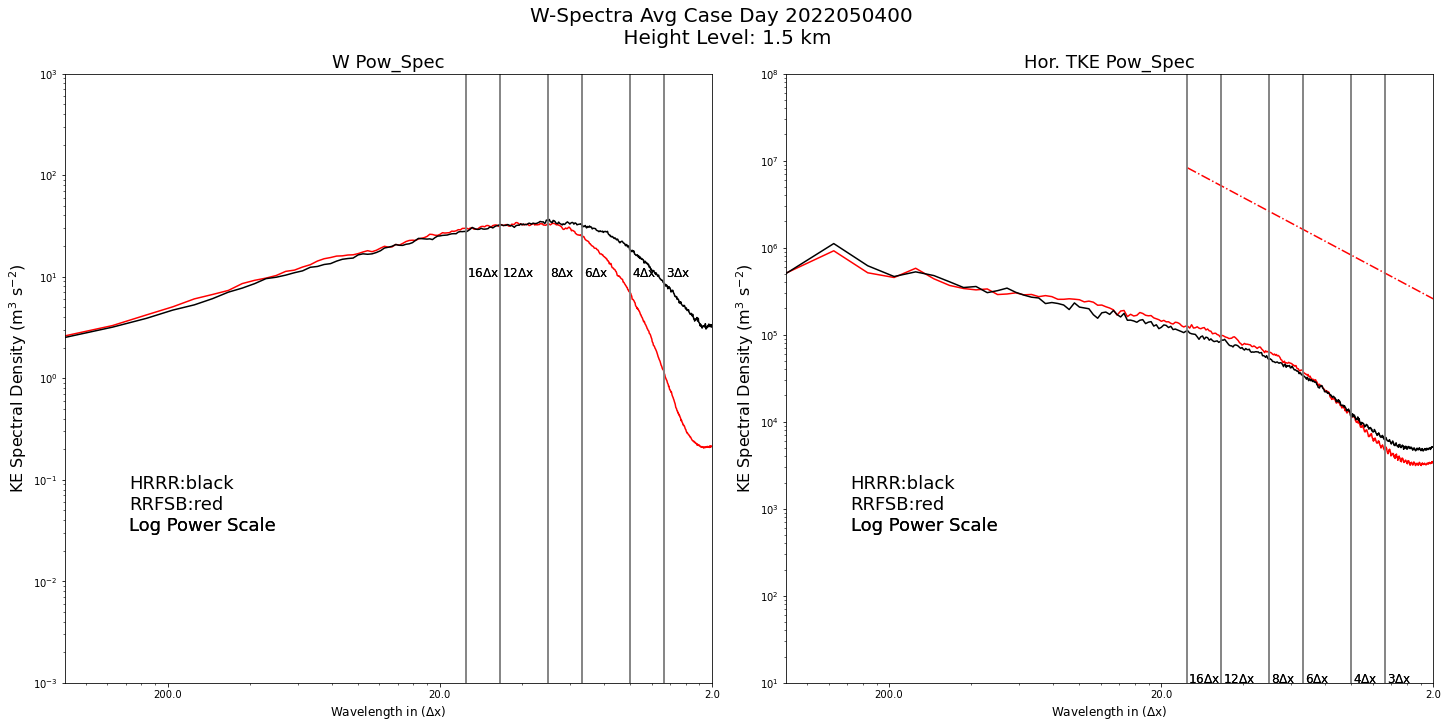

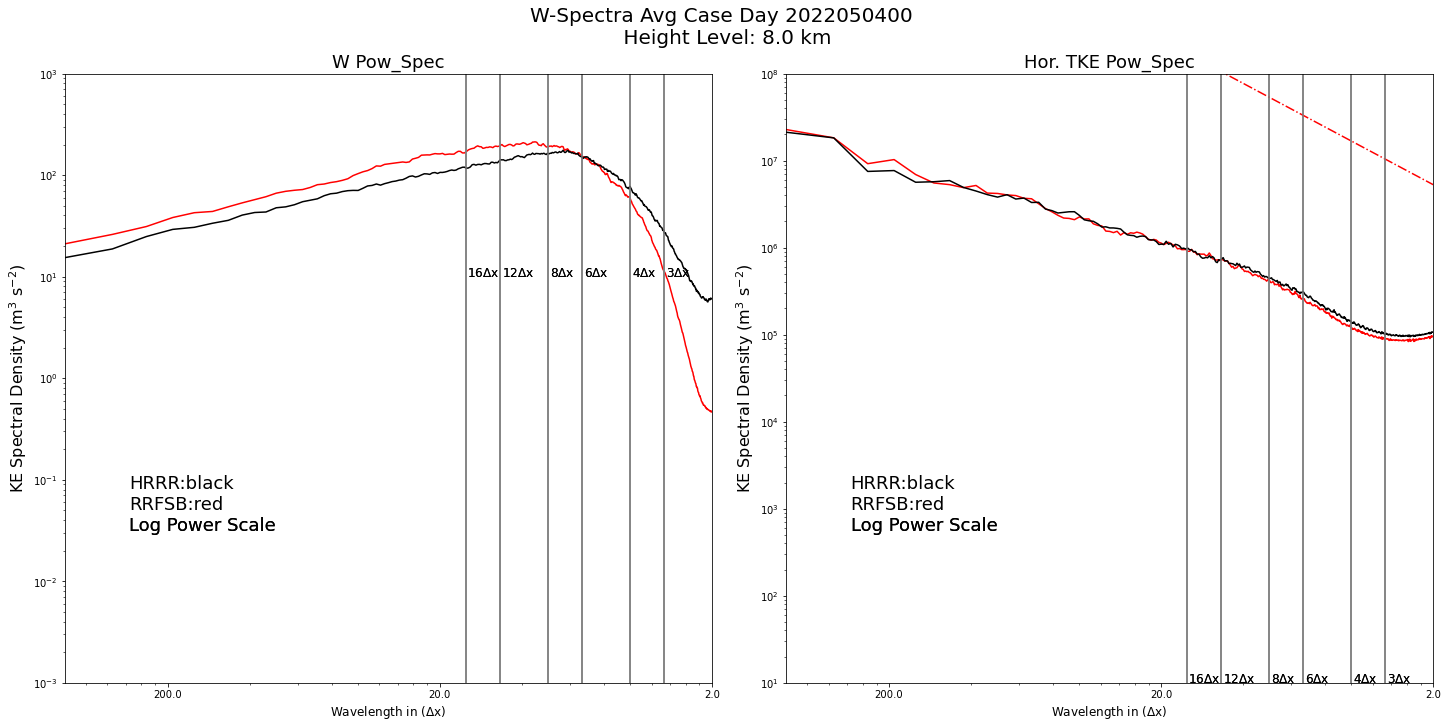

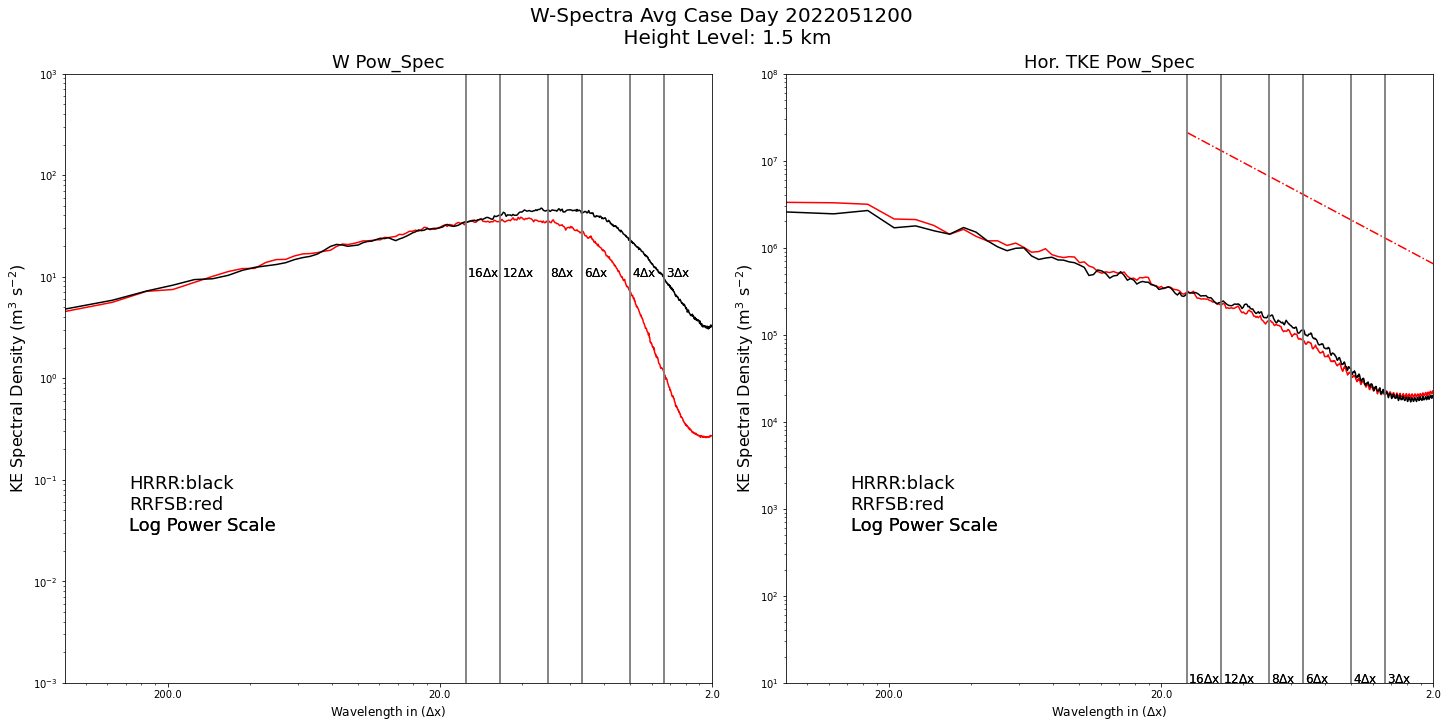

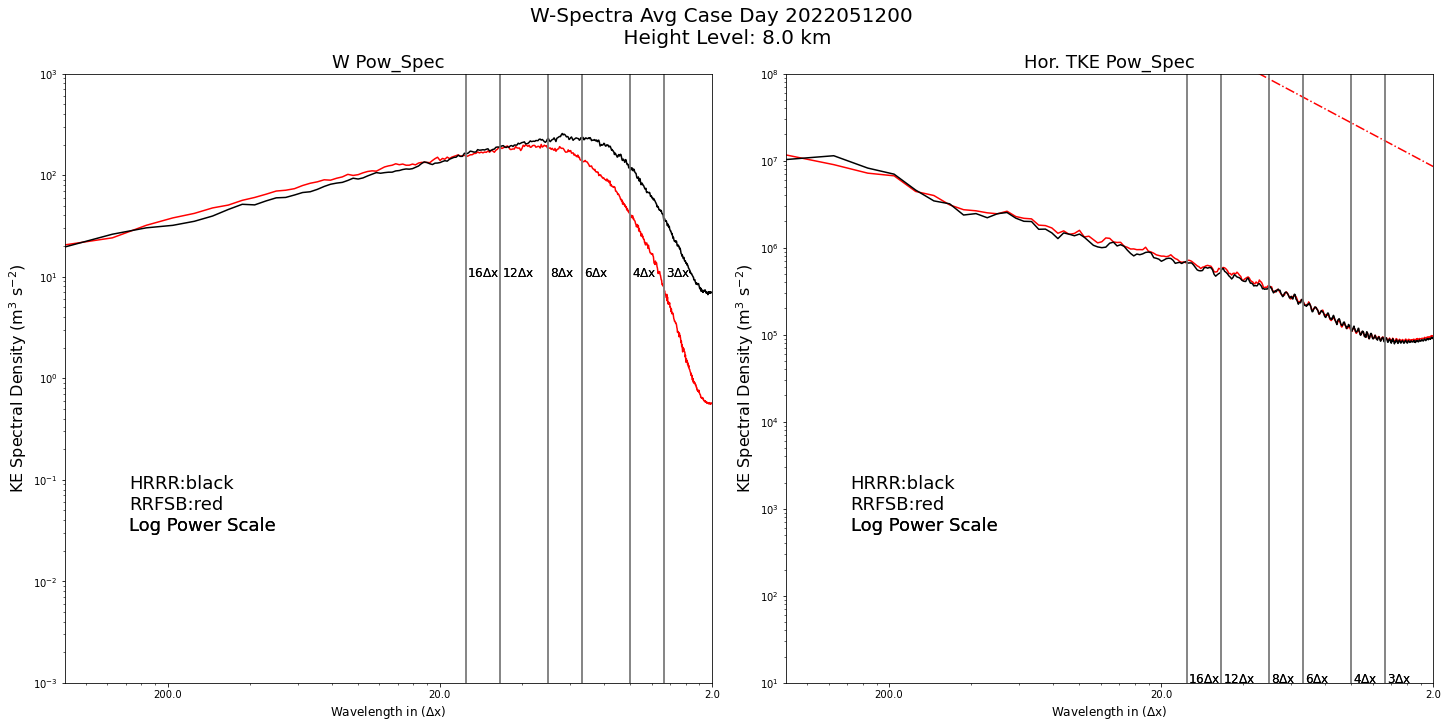

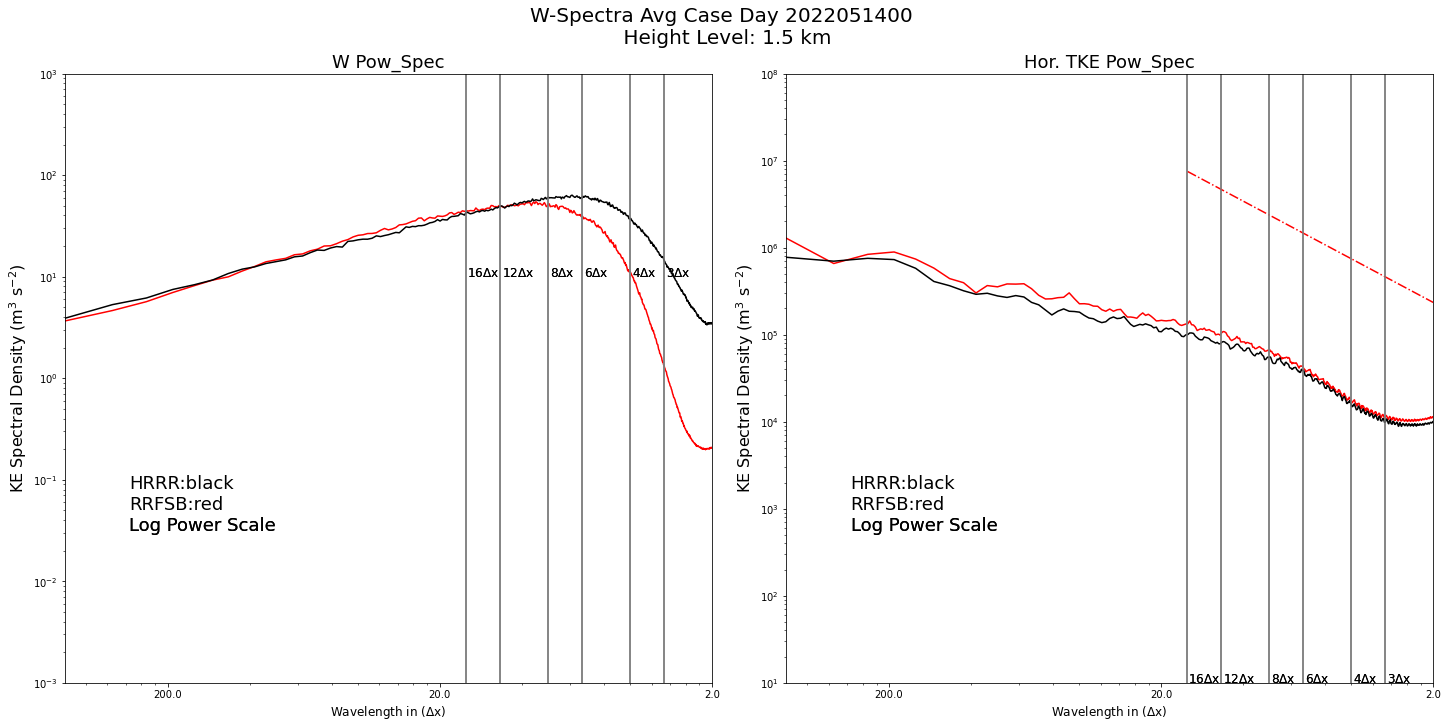

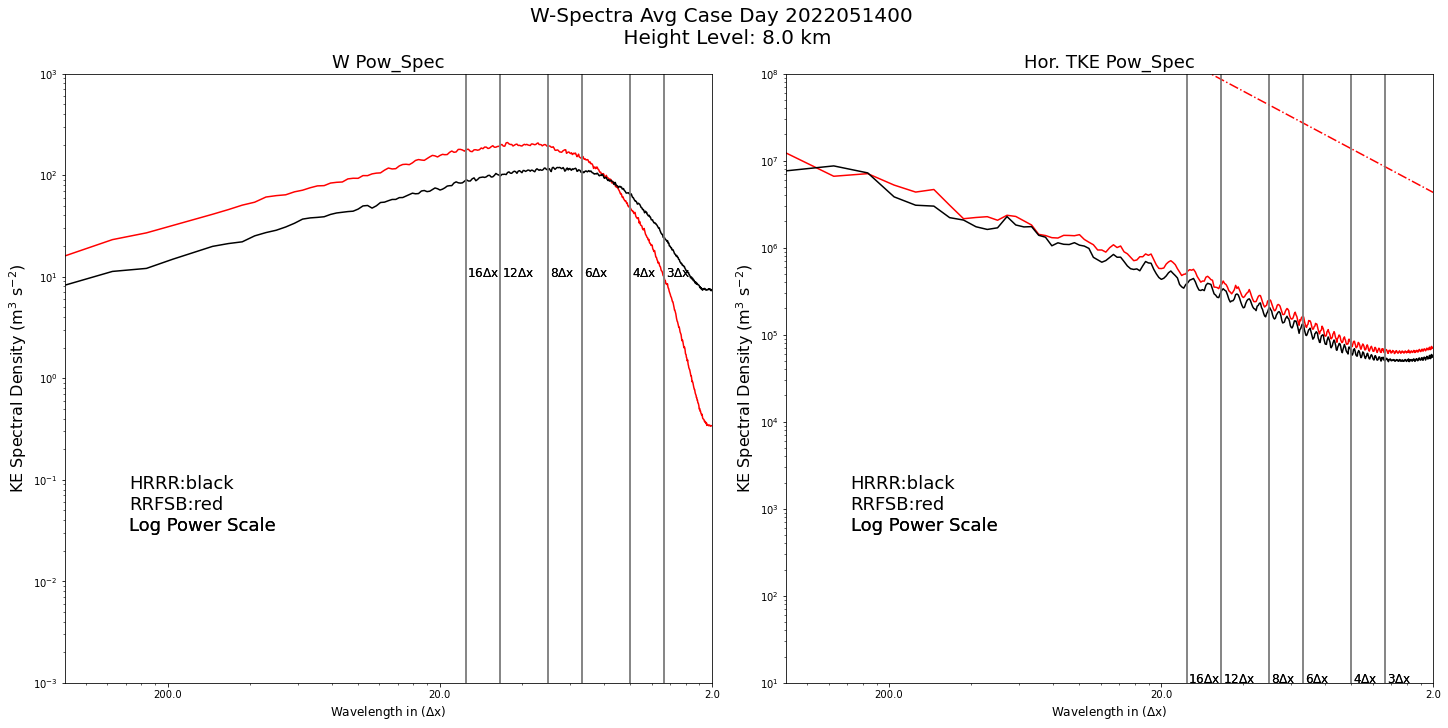

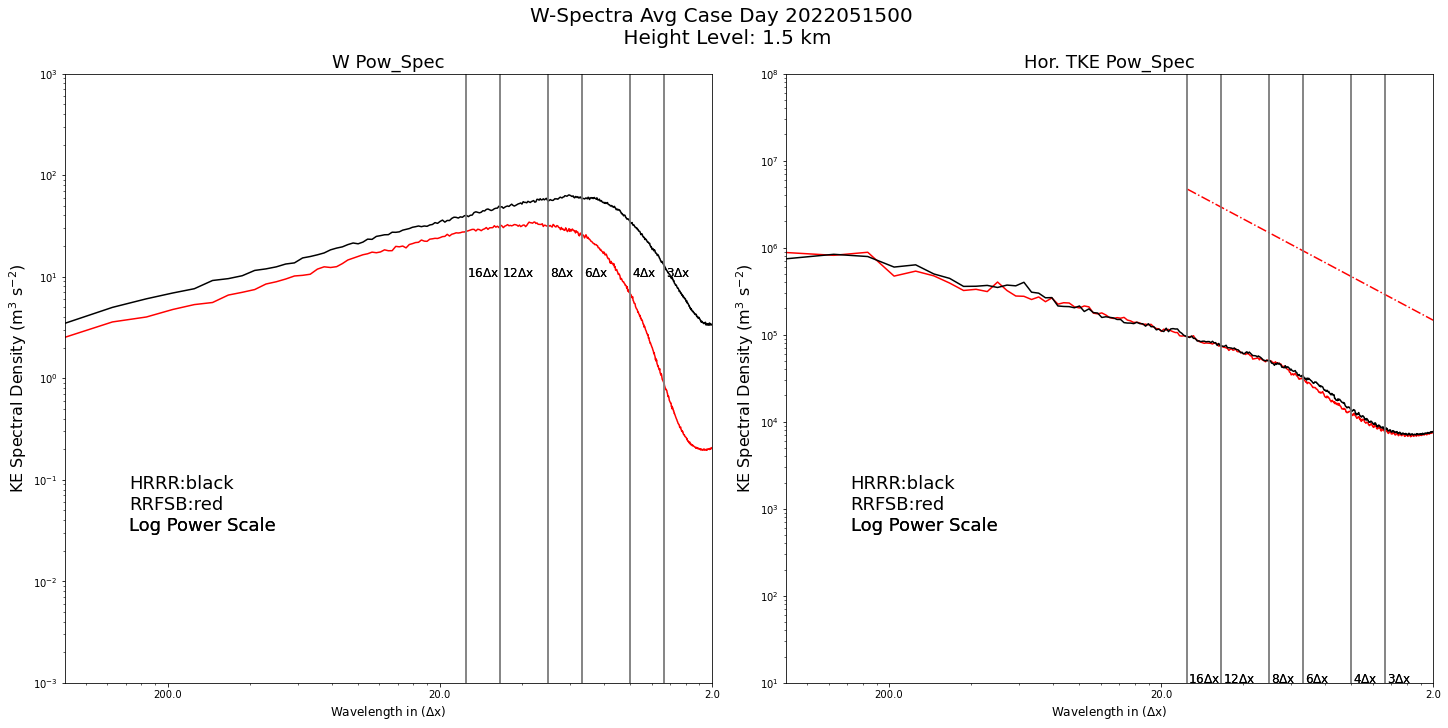

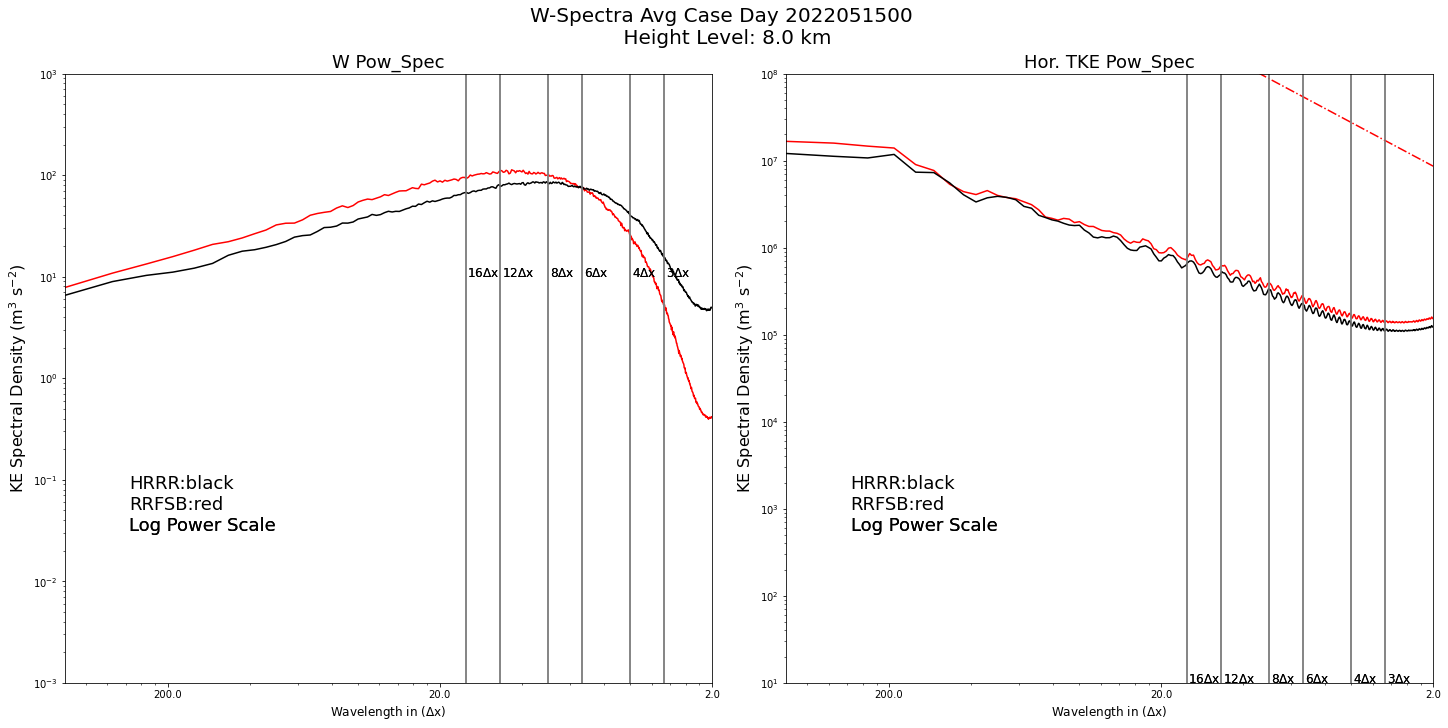

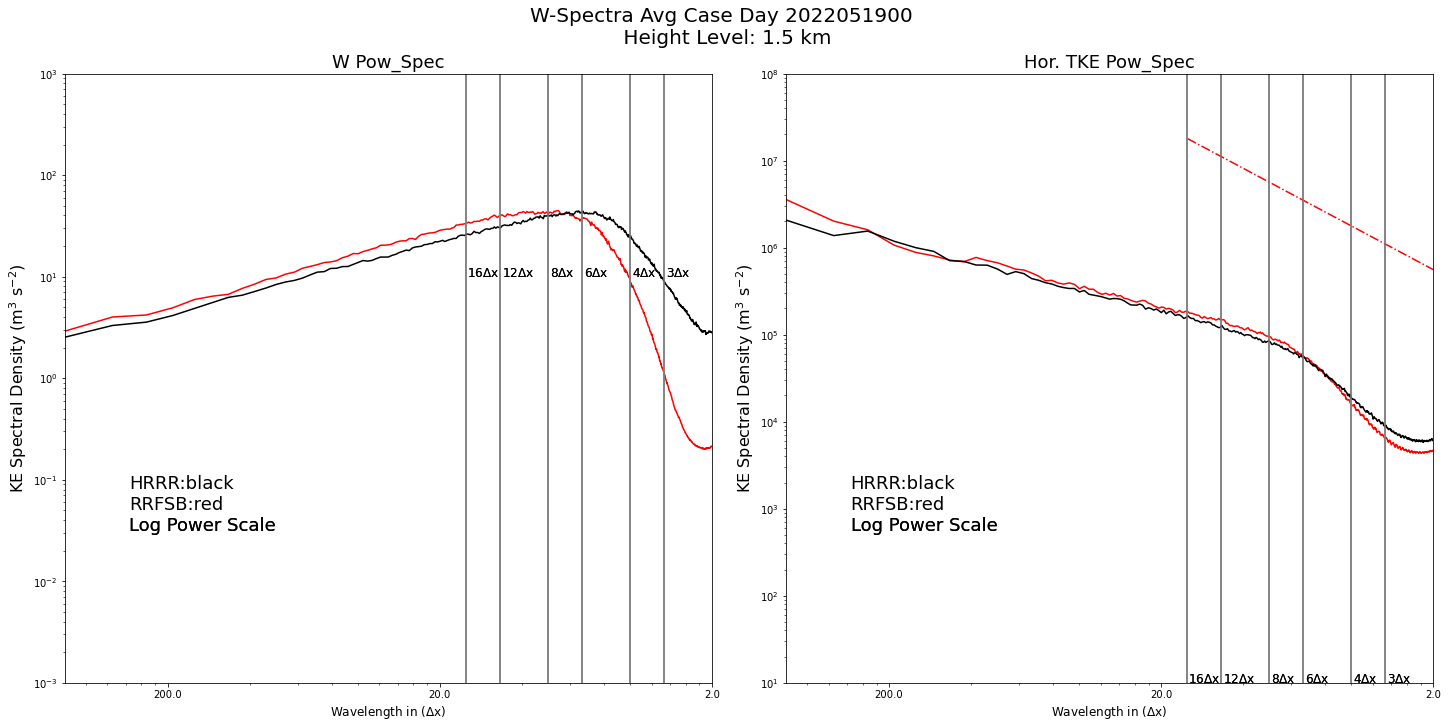

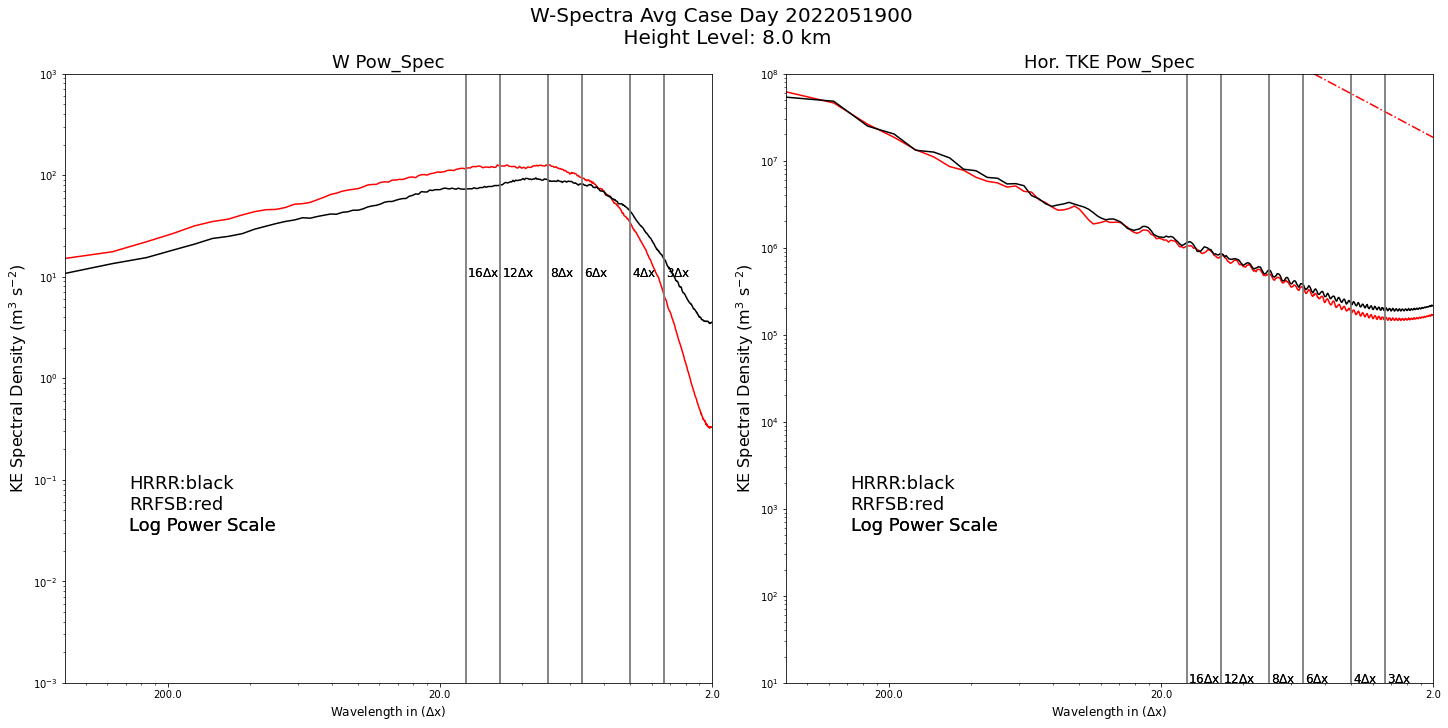

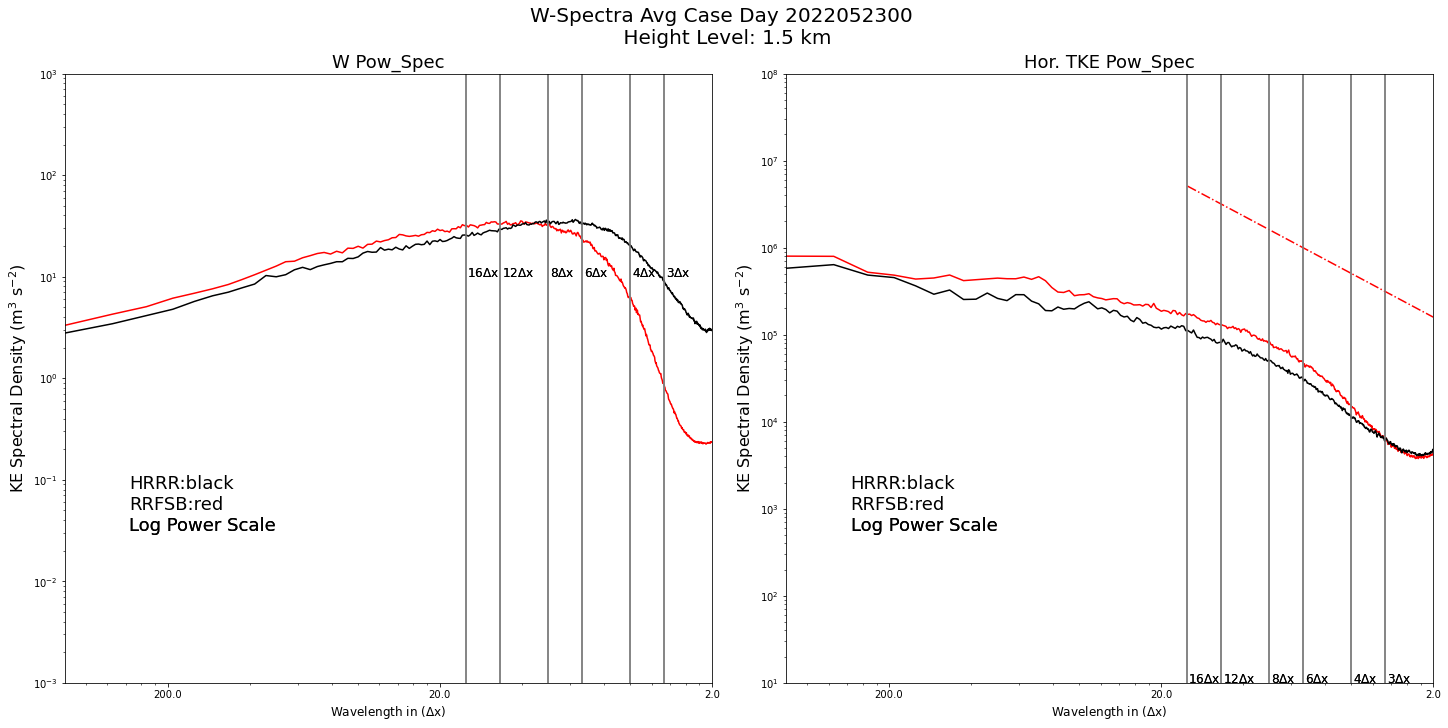

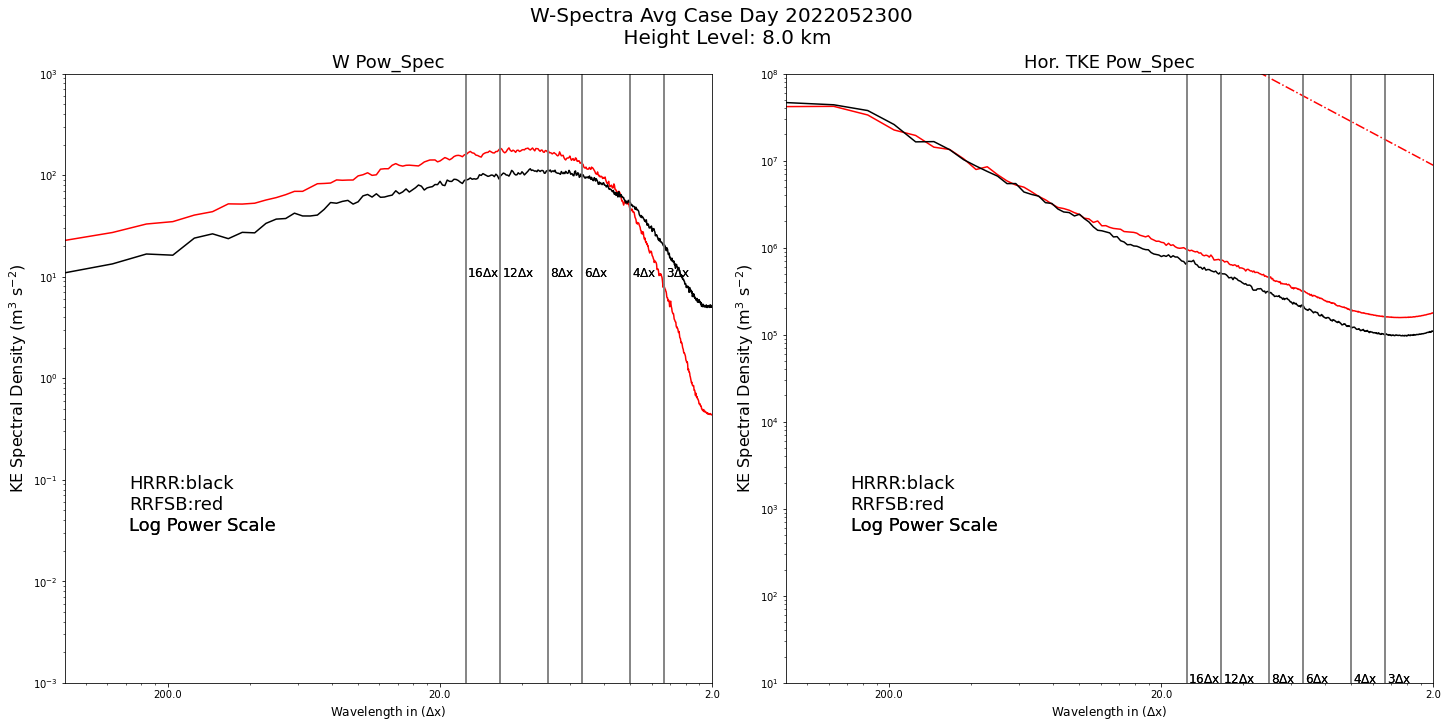

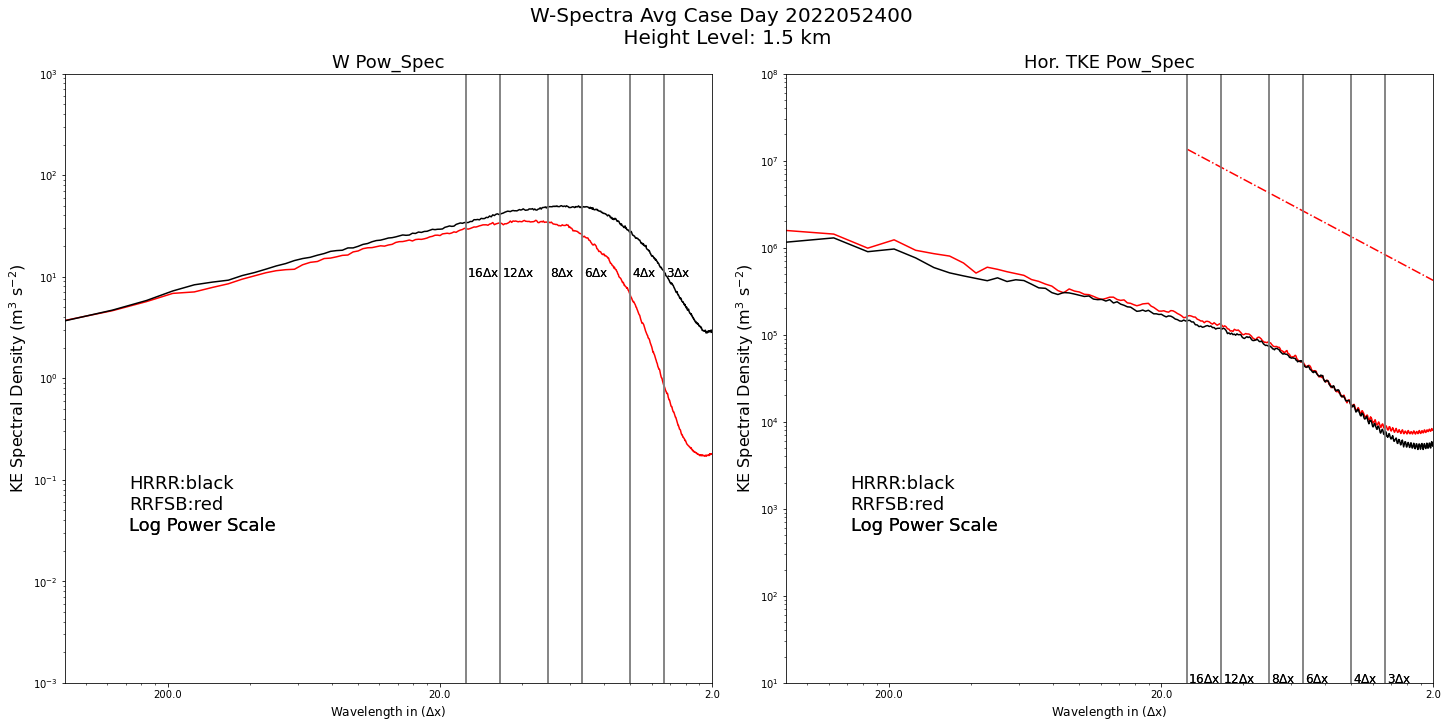

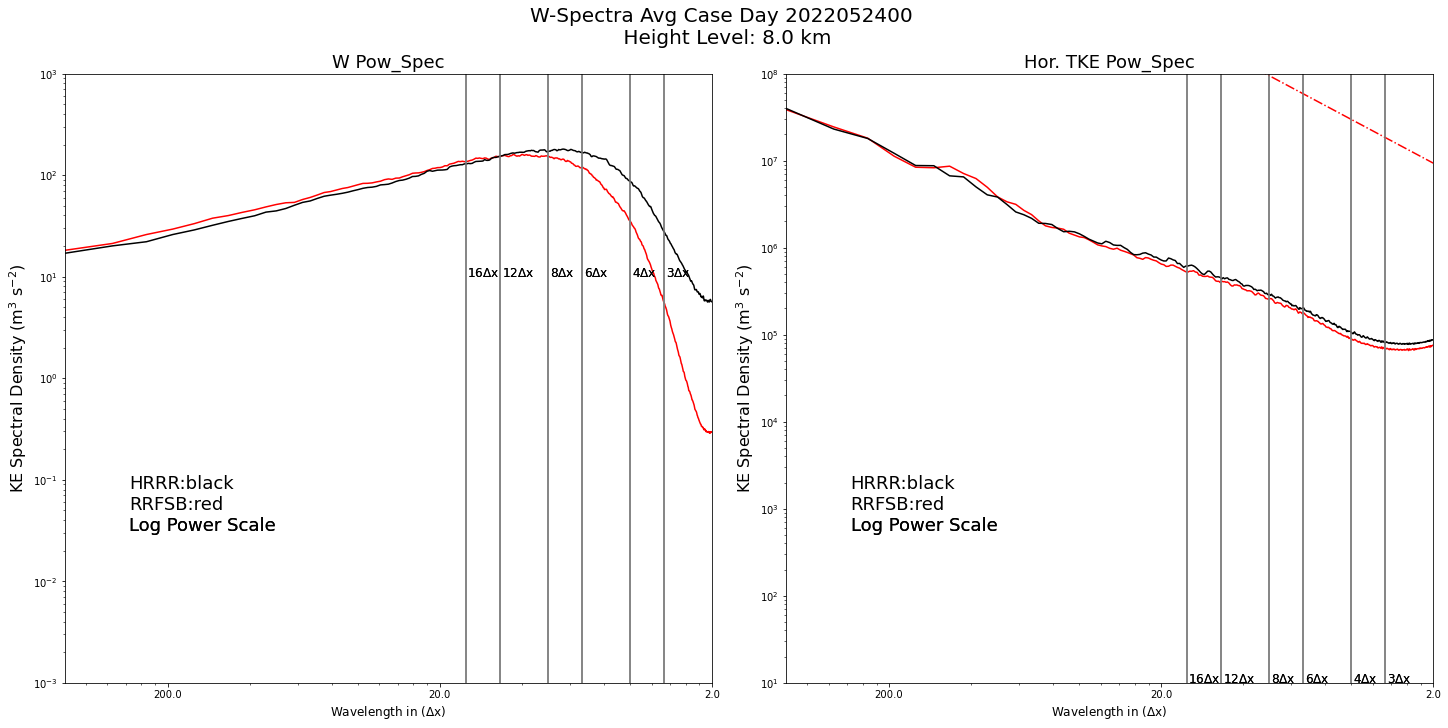

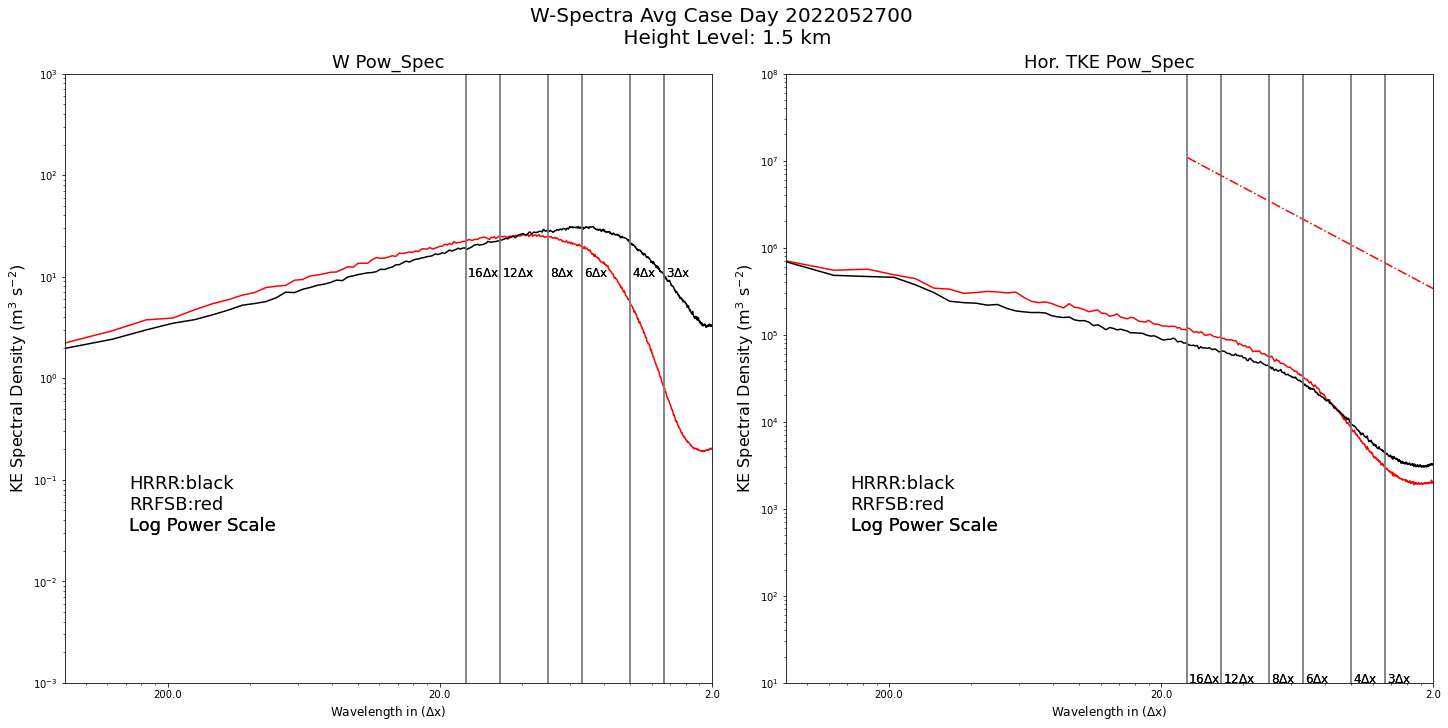

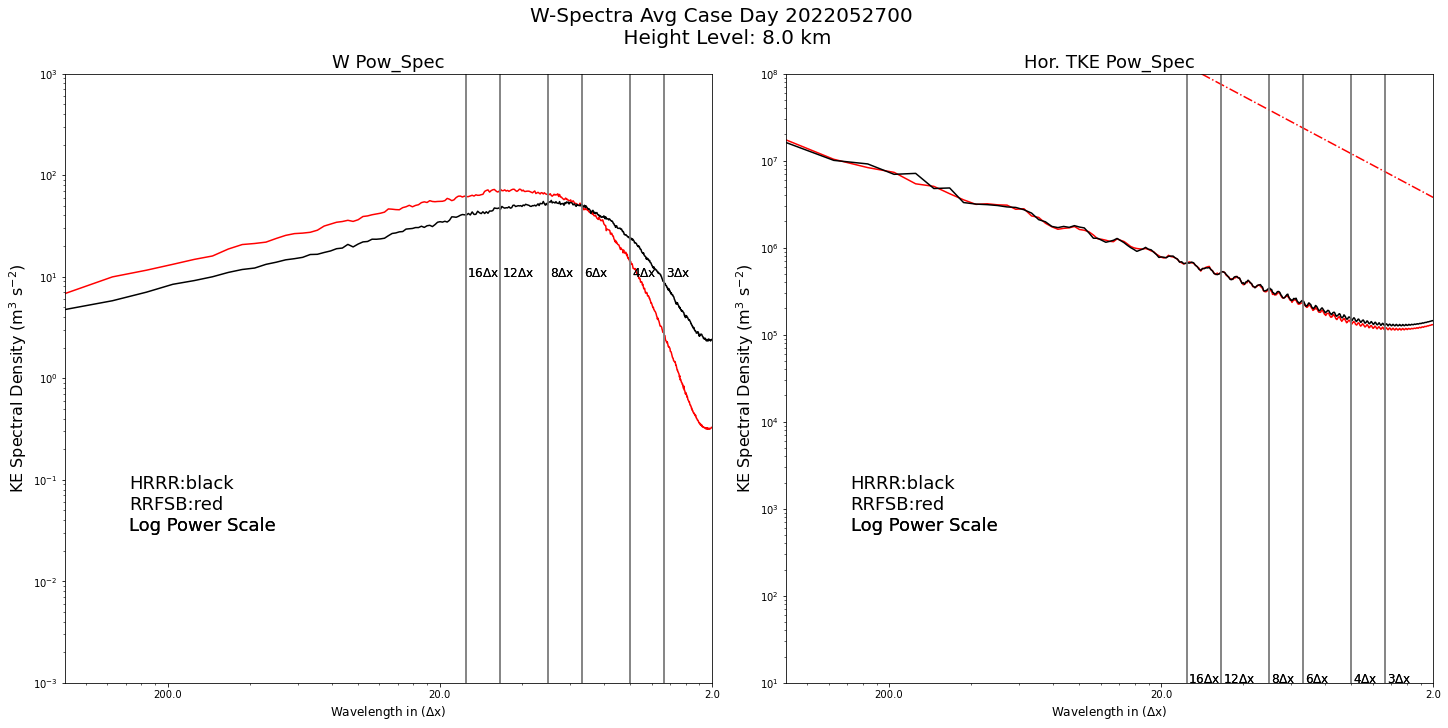

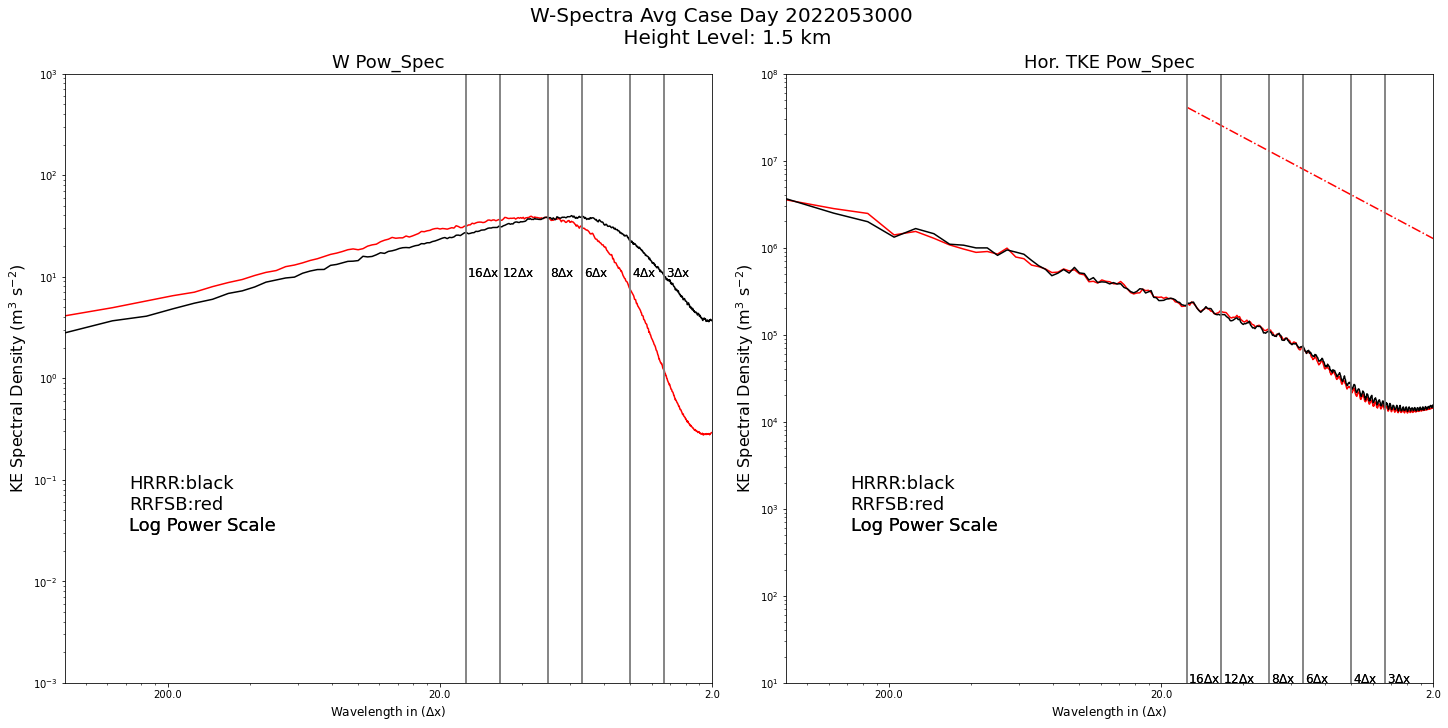

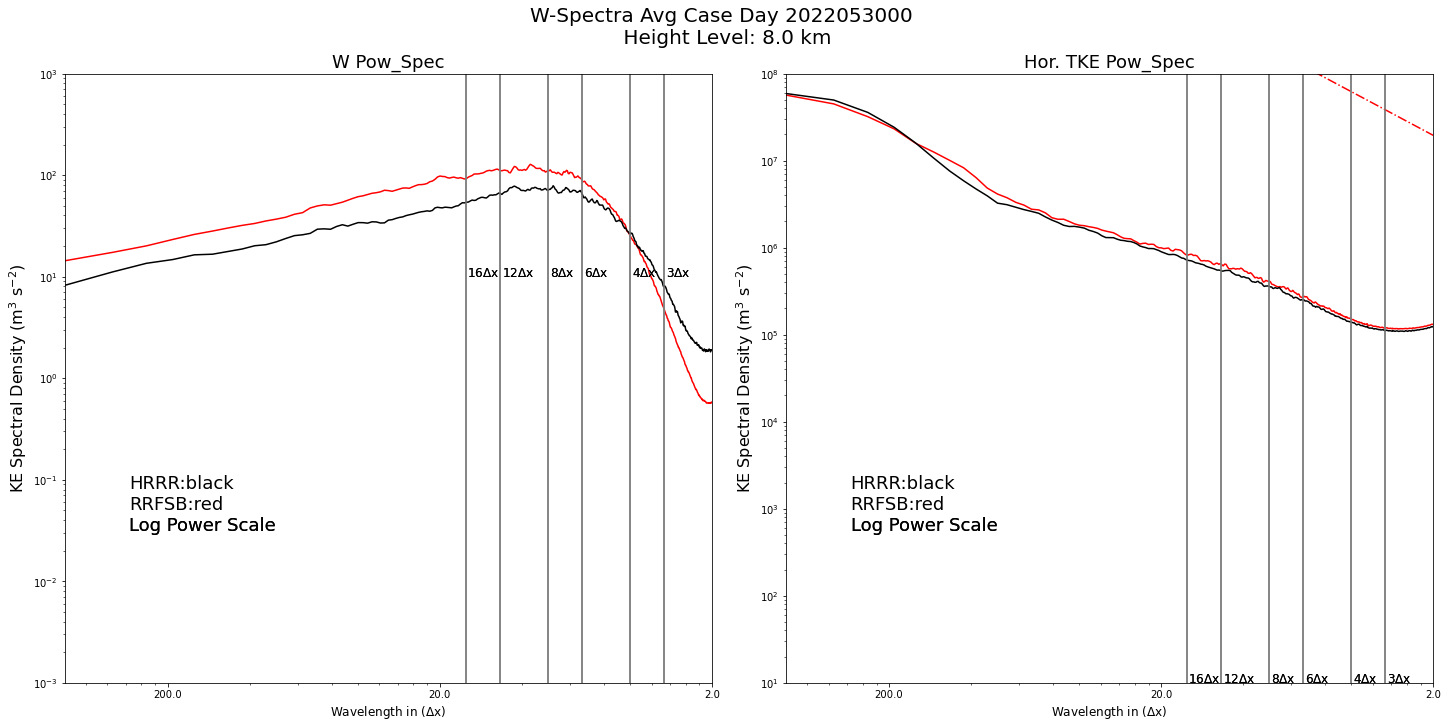

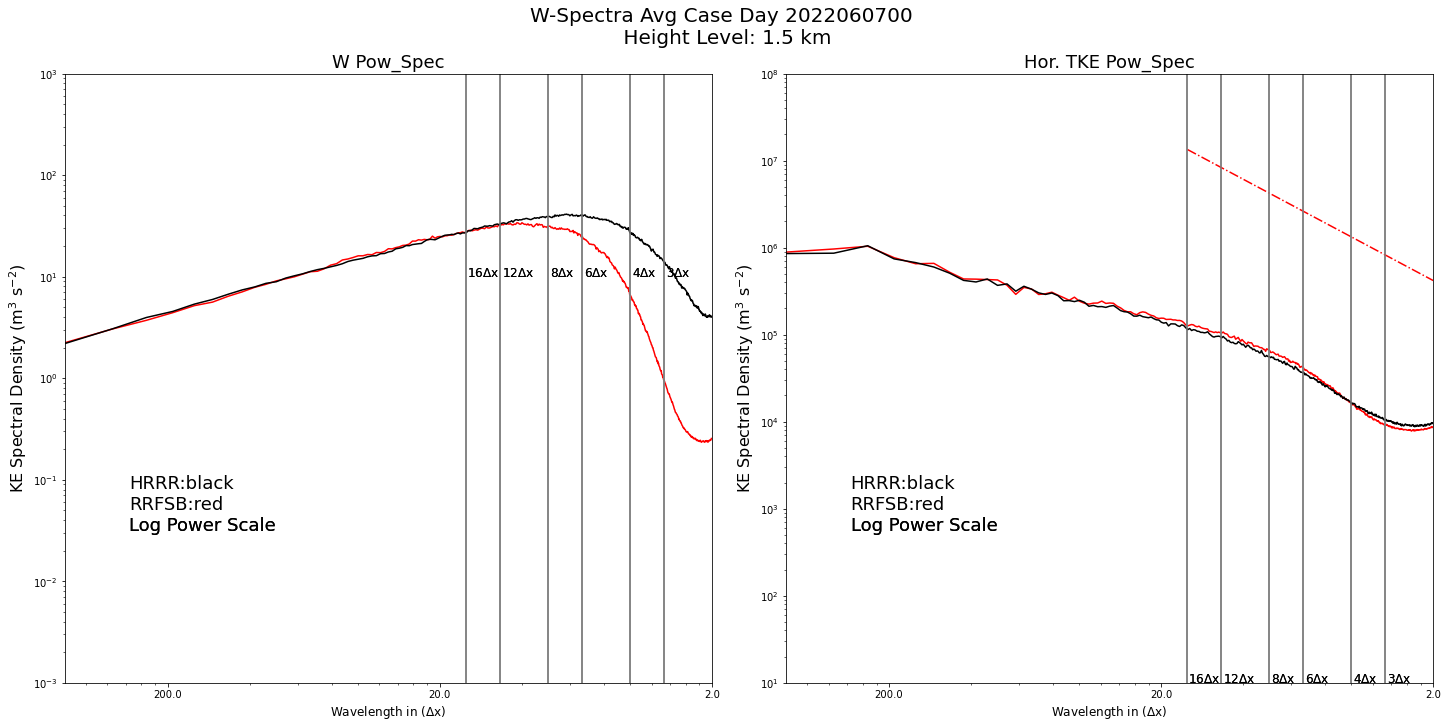

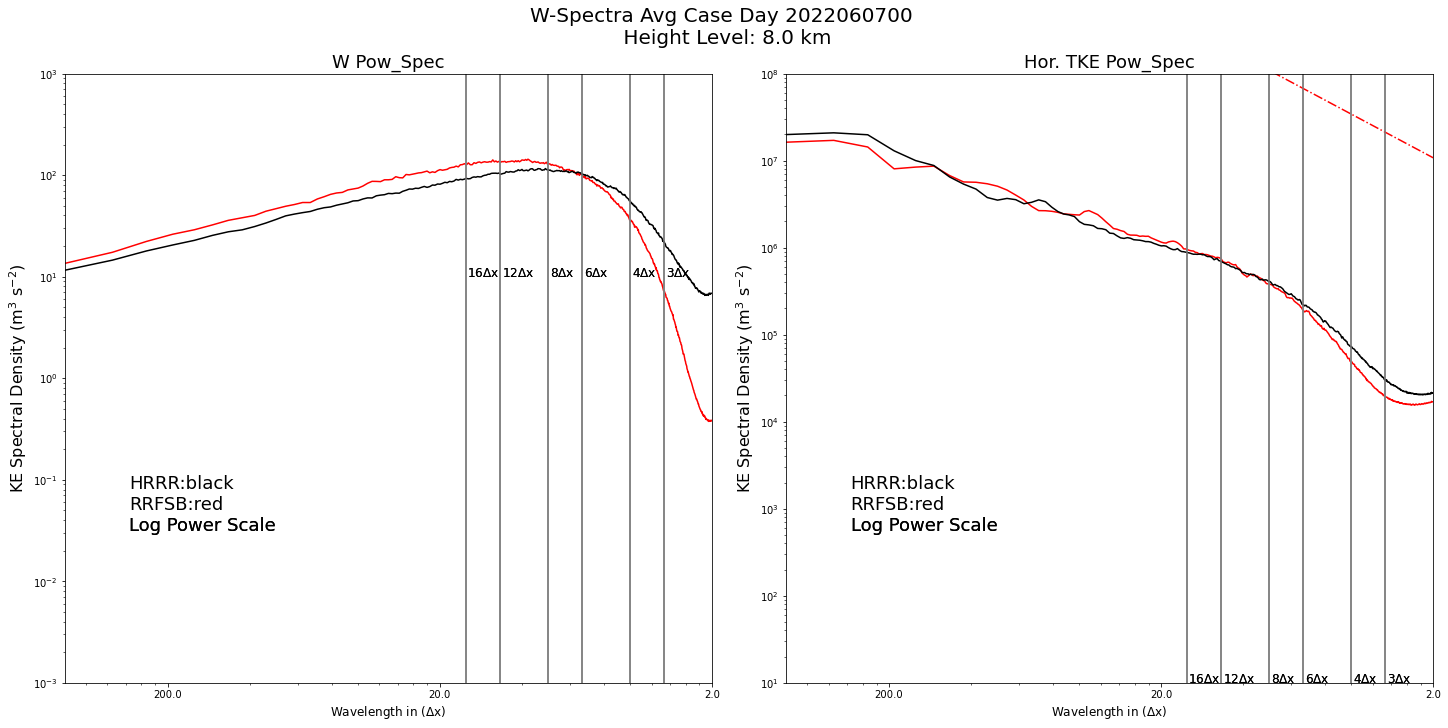

In [10]:
in_dir  = "/work/wicker"
out_dir = "/work/wicker/CAM_analysis_tools/2022_spectra"
case_days = ["2022050400",
            "2022051200",
            "2022051400",
            "2022051500",
            "2022051900",
            "2022052300",
            "2022052400",
            "2022052700",
            "2022053000",
            "2022060700"]

for d in case_days:
    print("Running day:  %s\n" % d)
    ret = run_spectral_analysis(in_dir, out_dir, d)


====> Begin processing runs


----> Processing run: HRRR for day:  2022050400 

/work/wicker/2022050400_HRRR_ECONUS.nc

----------------------
get_spectraND called
----------------------

get_spectraND:  Reshaped array so that spectra averaged over outer dimension: 18


----> Processing run: RRFS for day:  2022050400 

/work/wicker/2022050400_RRFS_ECONUS.nc

----------------------
get_spectraND called
----------------------

get_spectraND:  Reshaped array so that spectra averaged over outer dimension: 18


----> Processing run: HRRR for day:  2022051200 

/work/wicker/2022051200_HRRR_ECONUS.nc

----------------------
get_spectraND called
----------------------

get_spectraND:  Reshaped array so that spectra averaged over outer dimension: 21


----> Processing run: RRFS for day:  2022051200 

/work/wicker/2022051200_RRFS_ECONUS.nc

----------------------
get_spectraND called
----------------------

get_spectraND:  Reshaped array so that spectra averaged over outer dimension: 21


---->

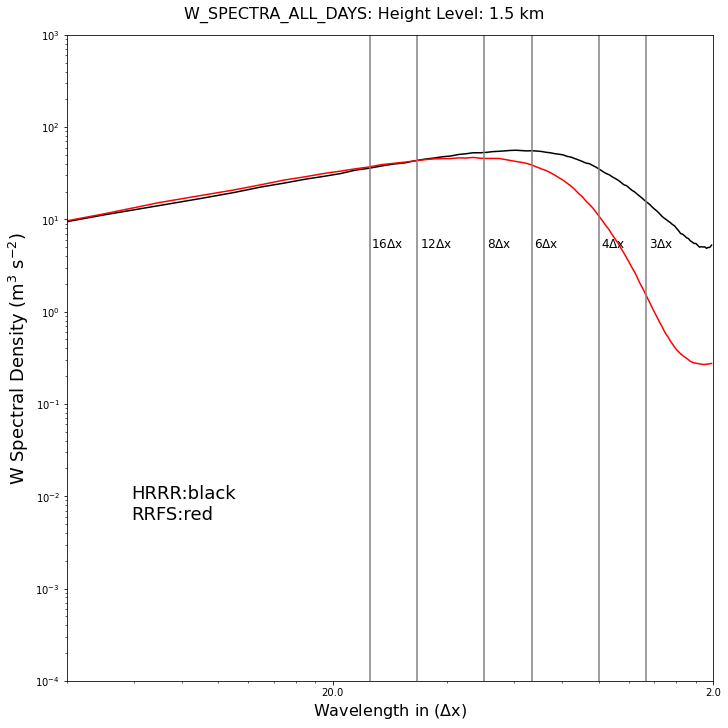

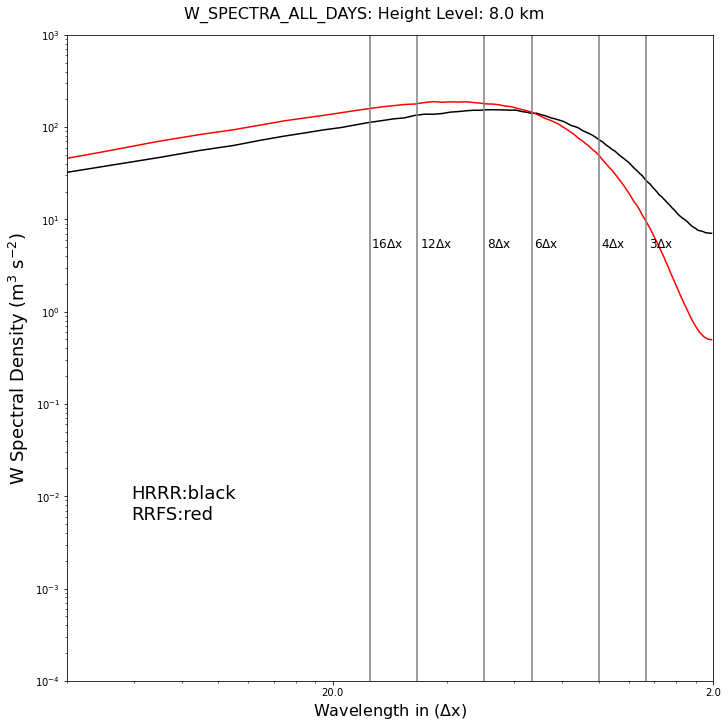

In [19]:
import matplotlib.ticker as mticker

def update_ticks(x, pos):
    if x != 0.0:
        return "%2.1f" % (2.0/x)
    else:
        return r'$\infty$'

in_dir  = "/work/wicker"
out_dir = "/work/wicker/CAM_analysis_tools/2022_spectra"
case_days = ["2022050400",
            "2022051200",
            "2022051400",
            "2022051500",
            "2022051900",
            "2022052300",
            "2022052400",
            "2022052700",
            "2022053000",
            "2022060700"]

ncases = len(case_days)

avg_grid = 0.005 + 0.985* np.linspace(0.0, 1.0, num=100, endpoint=True)

ret_data =  {"HRRR":[], 
             "RRFS":[]}

avg_data = {"HRRR":np.zeros((ncases,avg_grid.shape[0],)), 
            "RRFS":np.zeros((ncases,avg_grid.shape[0],))}

func = get_spectra2D_AVG
axis = None

delta = False
#------------------------------------------------------------------------------------
#

print("\n====> Begin processing runs\n")

for k in analysis_levels:
    for n, day in enumerate(case_days):
        for run in ["HRRR","RRFS"]:

            print("\n----> Processing run: %s for day:  %s \n" % (run,day))
            
            myfile  = str(os.path.join(in_dir, "%s_%s_ECONUS.nc" % (day, run)))
            print(myfile)

            # Open data set

            data = xr.open_dataset(myfile)
            # Loop over the analy_klevels to create multiple plots

            # these five levels are averaged together

            klevels = [k-1, k, k+1]

            # Convert to numpy arrays, fill in zeros, compute horizontal TKE.

            data_w = np.nan_to_num(data.w_interp.isel(nz=klevels).values).astype('float64')

            # Compute spectra...

            ret = get_spectraND(data_w, func = func)

            ret_data[run].append(ret)

            avg_data[run][n][:] = np.interp(avg_grid, ret[2], ret[1])
            
            data.close()


# Now post the runs....

    legend='HRRR:black\nRRFS:red'

    avg_hrrr = avg_data['HRRR'].mean(axis=0)
    avg_rrfs = avg_data['RRFS'].mean(axis=0)

    fig, axes = plt.subplots(1, 1, constrained_layout=True,figsize=(10,10))

    if delta:
        delta_rrfs = avg_rrfs[12]-avg_hrrr[12]
        axes.loglog(avg_grid, avg_hrrr+delta_rrfs,  color='black')
    else:
        axes.loglog(avg_grid, avg_hrrr,  color='black')
        
    axes.loglog(avg_grid, avg_rrfs, color='red')
    
    axes.set_xlim(2.0/avg_grid.shape[0], 1.0)

    axes.annotate("%s" % legend, xy=(0.10, 0.25), xycoords='axes fraction', color='k',fontsize=18)
    axes.xaxis.set_major_formatter(mticker.FuncFormatter(update_ticks))

    ylim = [0.0001,1000.0]
    
    axes.set_ylim(ylim[0], ylim[1])

    ylabel = 5.

    xoffset = [0.01, 0.0075, 0.005, 0.0035, 0.0025, 0.001]

    for n, w in enumerate([3.0, 4.0, 6.0, 8.0, 12.0, 16.0]):
        axes.axvline(x = (2.0/w), color = 'grey', label = 'axvline - full height')  
        axes.annotate(r"%d$\Delta$x" % w, xy=(2.0/w + xoffset[n], ylabel), xycoords='data', color='k',fontsize=12)

    axes.set_xlabel(r"Wavelength in ($\Delta$x)", fontsize=16)
    axes.set_ylabel(r"W Spectral Density (m$^3$ s$^{-2}$)", fontsize=18)

    # plt.title(ptitle, fontsize=18)

    plt.suptitle("W_SPECTRA_ALL_DAYS: Height Level: %3.1f km" % (zlevels[k]/1000.), fontsize=16)

    plt.savefig("%s/%s_%3.1fkm.png" % (out_dir, 'W_SPECTRA_ALL', zlevels[k]/1000.),bbox_inches='tight',dpi=300)




====> Begin processing runs


----> Processing run: HRRR for day:  2022050400 

/work/wicker/2022050400_HRRR_ECONUS.nc

----------------------
get_spectraND called
----------------------

get_spectraND:  Reshaped array so that spectra averaged over outer dimension: 18


----> Processing run: RRFS for day:  2022050400 

/work/wicker/2022050400_RRFS_ECONUS.nc

----------------------
get_spectraND called
----------------------

get_spectraND:  Reshaped array so that spectra averaged over outer dimension: 18


----> Processing run: HRRR for day:  2022051200 

/work/wicker/2022051200_HRRR_ECONUS.nc

----------------------
get_spectraND called
----------------------

get_spectraND:  Reshaped array so that spectra averaged over outer dimension: 21


----> Processing run: RRFS for day:  2022051200 

/work/wicker/2022051200_RRFS_ECONUS.nc

----------------------
get_spectraND called
----------------------

get_spectraND:  Reshaped array so that spectra averaged over outer dimension: 21


---->

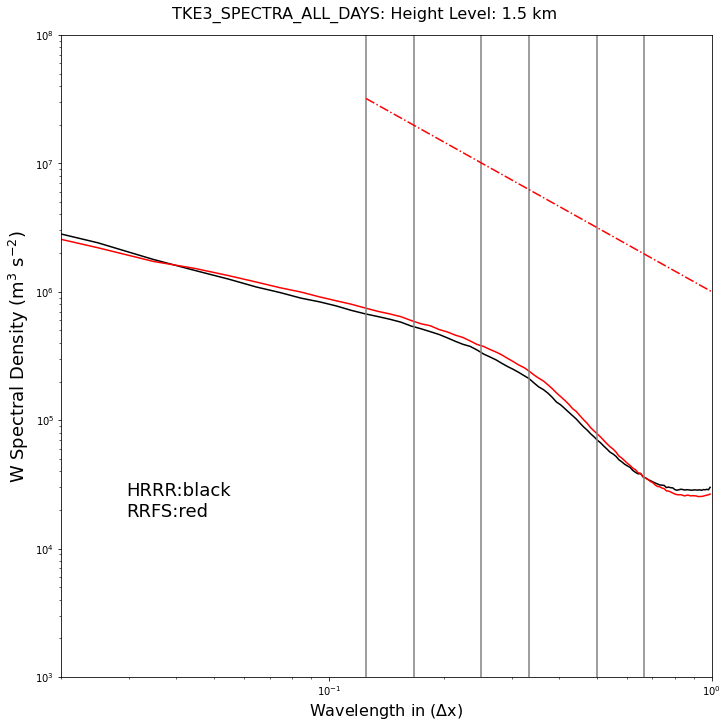

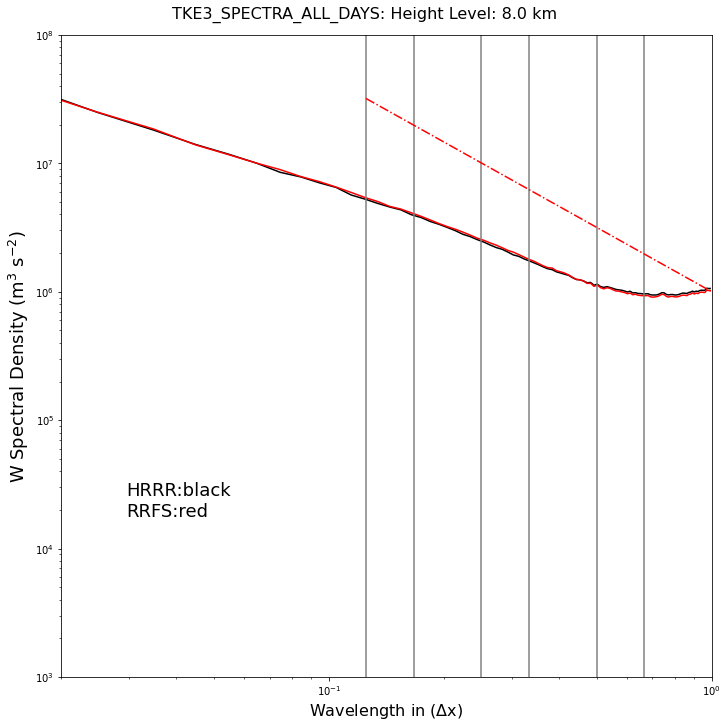

In [26]:
import matplotlib.ticker as mticker

def update_ticks(x, pos):
    if x != 0.0:
        return "%2.1f" % (2.0/x)
    else:
        return r'$\infty$'

in_dir  = "/work/wicker"
out_dir = "/work/wicker/CAM_analysis_tools/2022_spectra"
case_days = ["2022050400",
            "2022051200",
            "2022051400",
            "2022051500",
            "2022051900",
            "2022052300",
            "2022052400",
            "2022052700",
            "2022053000",
            "2022060700"]

ncases = len(case_days)

avg_grid = 0.005 + 0.985* np.linspace(0.0, 1.0, num=100, endpoint=True)

ret_data =  {"HRRR":[], 
             "RRFS":[]}

avg_data = {"HRRR":np.zeros((ncases,avg_grid.shape[0],)), 
            "RRFS":np.zeros((ncases,avg_grid.shape[0],))}

func = get_spectra2D_AVG
axis = None

delta = False
#------------------------------------------------------------------------------------
#

print("\n====> Begin processing runs\n")

for k in analysis_levels:
    for n, day in enumerate(case_days):
        for run in ["HRRR","RRFS"]:

            print("\n----> Processing run: %s for day:  %s \n" % (run,day))
            
            myfile  = str(os.path.join(in_dir, "%s_%s_ECONUS.nc" % (day, run)))
            print(myfile)

            # Open data set

            data = xr.open_dataset(myfile)
            # Loop over the analy_klevels to create multiple plots

            # these five levels are averaged together

            klevels = [k-1, k, k+1]

            # Convert to numpy arrays, fill in zeros, compute horizontal TKE.

            data_u = np.nan_to_num(data.u_interp.isel(nz=klevels).values).astype('float64')
            data_v = np.nan_to_num(data.u_interp.isel(nz=klevels).values).astype('float64')
            data_w = np.nan_to_num(data.u_interp.isel(nz=klevels).values).astype('float64')
            

            tke2 = 0.5*(data_u**2 + data_v**2 + data_w**2)

            # Compute spectra...

            ret = get_spectraND(tke2, func = func)

            ret_data[run].append(ret)

            avg_data[run][n][:] = np.interp(avg_grid, ret[2], ret[1])
            
            data.close()


# Now post the runs....

    legend='HRRR:black\nRRFS:red'

    avg_hrrr = avg_data['HRRR'].mean(axis=0)
    avg_rrfs = avg_data['RRFS'].mean(axis=0)

    fig, axes = plt.subplots(1, 1, constrained_layout=True,figsize=(10,10))

    if delta:
        delta_rrfs = avg_rrfs[12]-avg_hrrr[12]
        axes.loglog(avg_grid, avg_hrrr+delta_rrfs,  color='black')
    else:
        axes.loglog(avg_grid, avg_hrrr,  color='black')
        
    axes.loglog(avg_grid, avg_rrfs, color='red')
    
    axes.set_xlim(2.0/avg_grid.shape[0], 1.0)

    axes.annotate("%s" % legend, xy=(0.10, 0.25), xycoords='axes fraction', color='k',fontsize=18)
    axes.xaxis.set_major_formatter(mticker.FuncFormatter(update_ticks))

    ylim = [1000.,1.0e8]
    
    axes.set_ylim(ylim[0], ylim[1])

    ylabel = 5.

    xoffset = [0.01, 0.0075, 0.005, 0.0035, 0.0025, 0.001]

    for n, w in enumerate([3.0, 4.0, 6.0, 8.0, 12.0, 16.0]):
        axes.axvline(x = (2.0/w), color = 'grey', label = 'axvline - full height')  
        axes.annotate(r"%d$\Delta$x" % w, xy=(2.0/w + xoffset[n], ylabel), xycoords='data', color='k',fontsize=12)
        
    xpt = [2.0/16.,2.0/2.0]
    dlnx = np.log(xpt[1]) - np.log(xpt[0])
    y1   = ylim[1]/(100.)
    y0   = np.exp(np.log(y1) + 5./3. * dlnx)
    ypt  = [y0,y1]
    axes.loglog(xpt, ypt, color='red',linestyle='-.',label='k$^{-5/3}$')

    axes.set_xlabel(r"Wavelength in ($\Delta$x)", fontsize=16)
    axes.set_ylabel(r"W Spectral Density (m$^3$ s$^{-2}$)", fontsize=18)

    plt.suptitle("TKE3_SPECTRA_ALL_DAYS: Height Level: %3.1f km" % (zlevels[k]/1000.), fontsize=16)

    plt.savefig("%s/%s_%3.1fkm.png" % (out_dir, 'TKE3_SPECTRA_ALL', zlevels[k]/1000.),bbox_inches='tight',dpi=300)
    
    